# Exploratory Data Analysis (EDA)

In this section we will explore our data.

This analysis will help us to develop an understanding of the nature of our data and help us to deliver better analysis during our presentation.

In addition this will assist us in predicting any shortcomings, outliers or systematic errors in our dataset.

## There are 3 main sections of this Data Exploration:

#### 1. Precise Descriptions of Data Fields and Units:

This involves clear and accurate explanations of each field, including units of measurement.

#### 2. Developing Summary Statistics, Correlation, Distributions, and Outliers:

Summary statistics, provide a concise overview of the dataset's central tendencies and variability. 

Correlation analysis reveals the linear relationships between key fields, while examining distributions and outliers provides insights into data patterns and potential anomalies.

#### 3. Appropriate Plots for Communicating Key Field Distributions and Illustrating Relationships Between Key Fields:

Visualisations help illustrate the distributional characteristics of key fields and offer a visual representation of data spread, central tendency and skew.

Scatter plots and heatmaps assist in visualising relationships between key fields. These plots enable us to see correlations, trends and patterns.

### 0.1 Load libraries and read in cleaned data

In [145]:
# load libraries
import pandas as pd
import os
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt

In [146]:
# load cleaned data
listings_df = pd.read_csv(os.path.join('data', 'yvr_listing_data_cleaned.csv'))

### 0.2 Create new key fields dataframe

In [147]:
# list of key fields
key_fields = [
    'host_response_rate',
    'number_of_reviews',
    'availability_365',
    'host_response_time',
    'beds',
    'review_scores_cleanliness',
    'minimum_nights',
    'room_type_Private room',
    'neighbourhood_cleansed_Grandview-Woodland',
    'neighbourhood_cleansed_Hastings-Sunrise',
    'neighbourhood_cleansed_Kensington-Cedar Cottage',
    'neighbourhood_cleansed_Mount Pleasant',
    'neighbourhood_cleansed_Riley Park',
    'neighbourhood_cleansed_Strathcona',
    'neighbourhood_cleansed_Victoria-Fraserview',
    'neighbourhood_cleansed_West Point Grey',
    'legal_listing'
]

key_fields_no_neighbourhoods = [
    'host_response_rate',
    'number_of_reviews',
    'availability_365',
    'host_response_time',
    'beds',
    'review_scores_cleanliness',
    'minimum_nights',
    'room_type_Private room',
    'legal_listing'
]

# create a new 'key fields' df
yvr_key_field_df = listings_df[key_fields]

# create a new 'key field w/o neighbourhoods' df for correlation analysis & boxplots
yvr_key_fields_no_neighbourhoods_df = listings_df[key_fields_no_neighbourhoods]

# print first 3 rows of yvr_key_field_df
yvr_key_field_df.head(3)

# save yvr_key_field_df to df
yvr_key_field_df.to_csv('key_fields_yvr_listing_data.csv', index=False)

# save yvr_key_fields_no_nieghbourhoods_df to df
yvr_key_fields_no_neighbourhoods_df.to_csv('yvr_key_fields_no_neighbourhoods_df.csv', index=False)

In [148]:
#read in key fields data
key_fields = pd.read_csv(os.path.join('data', 'key_fields_yvr_listing_data.csv'))

### 1. Precise descriptions of the data fields and their units of measurement: 
Gaining an understanding of the data, its fields and units of measurement

In [149]:
# take a look at new df
key_fields.head(5)

# display datatype


# display units of measurement


,host_response_rate,number_of_reviews,availability_365,host_response_time,beds,review_scores_cleanliness,minimum_nights,room_type_Private room,neighbourhood_cleansed_Grandview-Woodland,neighbourhood_cleansed_Hastings-Sunrise,neighbourhood_cleansed_Kensington-Cedar Cottage,neighbourhood_cleansed_Mount Pleasant,neighbourhood_cleansed_Riley Park,neighbourhood_cleansed_Strathcona,neighbourhood_cleansed_Victoria-Fraserview,neighbourhood_cleansed_West Point Grey,legal_listing
0,100.0,476.0,108.0,1.00,1.0,4.81,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,100.0,99.0,40.0,1.00,1.0,4.96,30.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,100.0,269.0,124.0,0.75,1.0,4.93,30.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,100.0,51.0,37.0,0.75,1.0,4.74,30.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,100.0,230.0,155.0,1.00,1.0,4.87,30.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


### 2. Developing Summary Statistics, Correlation, Distributions and Outliers

Develop an understanding of the spread of Inside Airbnb Data, identify outliers and 

#### 2.1 Summary statistics of key_fields

In [150]:
#print summary statistics for each column
print("\nSummary statistics:")
summary_stats = key_fields.describe()
summary_stats


Summary statistics:


,host_response_rate,number_of_reviews,availability_365,host_response_time,beds,review_scores_cleanliness,minimum_nights,room_type_Private room,neighbourhood_cleansed_Grandview-Woodland,neighbourhood_cleansed_Hastings-Sunrise,neighbourhood_cleansed_Kensington-Cedar Cottage,neighbourhood_cleansed_Mount Pleasant,neighbourhood_cleansed_Riley Park,neighbourhood_cleansed_Strathcona,neighbourhood_cleansed_Victoria-Fraserview,neighbourhood_cleansed_West Point Grey,legal_listing
count,3583.000000,3583.000000,3583.000000,3583.000000,3583.000000,3583.000000,3583.000000,3583.000000,3583.000000,3583.000000,3583.000000,3583.000000,3583.000000,3583.000000,3583.000000,3583.000000,3583.000000
mean,98.135361,53.075077,154.094055,0.934692,2.152665,4.790396,10.274072,0.025677,0.041864,0.043818,0.057773,0.067262,0.053586,0.006698,0.024002,0.016746,0.780073
std,8.103141,76.170987,118.226077,0.145271,1.176198,0.339462,12.495927,0.158191,0.200307,0.204719,0.233346,0.250510,0.225231,0.081580,0.153077,0.128335,0.414255
min,0.000000,1.000000,0.000000,0.250000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,100.000000,7.000000,52.000000,1.000000,1.000000,4.745000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,100.000000,24.000000,134.000000,1.000000,2.000000,4.890000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,100.000000,69.000000,266.000000,1.000000,3.000000,5.000000,30.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,100.000000,916.000000,365.000000,1.000000,12.000000,5.000000,30.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


#### 2.2 Calculate correlations between fields

In [151]:
# subset only numeric fields
numeric_key_fields = key_fields.select_dtypes(include=['number'])

# calculate correlation of fields with 'legal_listings' 
correlation_matrix = numeric_key_fields.corrwith(listings_df['legal_listing'])

# display correlation levels for 'legal_listings'
"\nCorrelation matrix with 'legal_listing':"
correlation_matrix

host_response_rate                                 0.074407
number_of_reviews                                  0.269131
availability_365                                  -0.164480
host_response_time                                 0.185734
beds                                               0.198417
review_scores_cleanliness                          0.092061
minimum_nights                                    -0.677698
room_type_Private room                            -0.033087
neighbourhood_cleansed_Grandview-Woodland          0.050430
neighbourhood_cleansed_Hastings-Sunrise            0.070870
neighbourhood_cleansed_Kensington-Cedar Cottage    0.079494
neighbourhood_cleansed_Mount Pleasant             -0.018824
neighbourhood_cleansed_Riley Park                  0.033590
neighbourhood_cleansed_Strathcona                  0.035342
neighbourhood_cleansed_Victoria-Fraserview         0.056852
neighbourhood_cleansed_West Point Grey             0.043037
legal_listing                           

In [155]:
# list > df
key_fields_df = pd.DataFrame({col: [] for col in key_fields})

# calculate the correlation matrix
correlation_matrix = key_fields_df.corr()

# calculate the correlation matrix
correlation_matrix = key_fields.corr()

#RUN THE FOLLOWING CODE TO DISPLAY CORRELATION MATRIX VALUES
print("\nCorrelation matrix for key_fields:")
print(correlation_matrix)

#### 2.2.1 Print Correlation Matrix of key fields

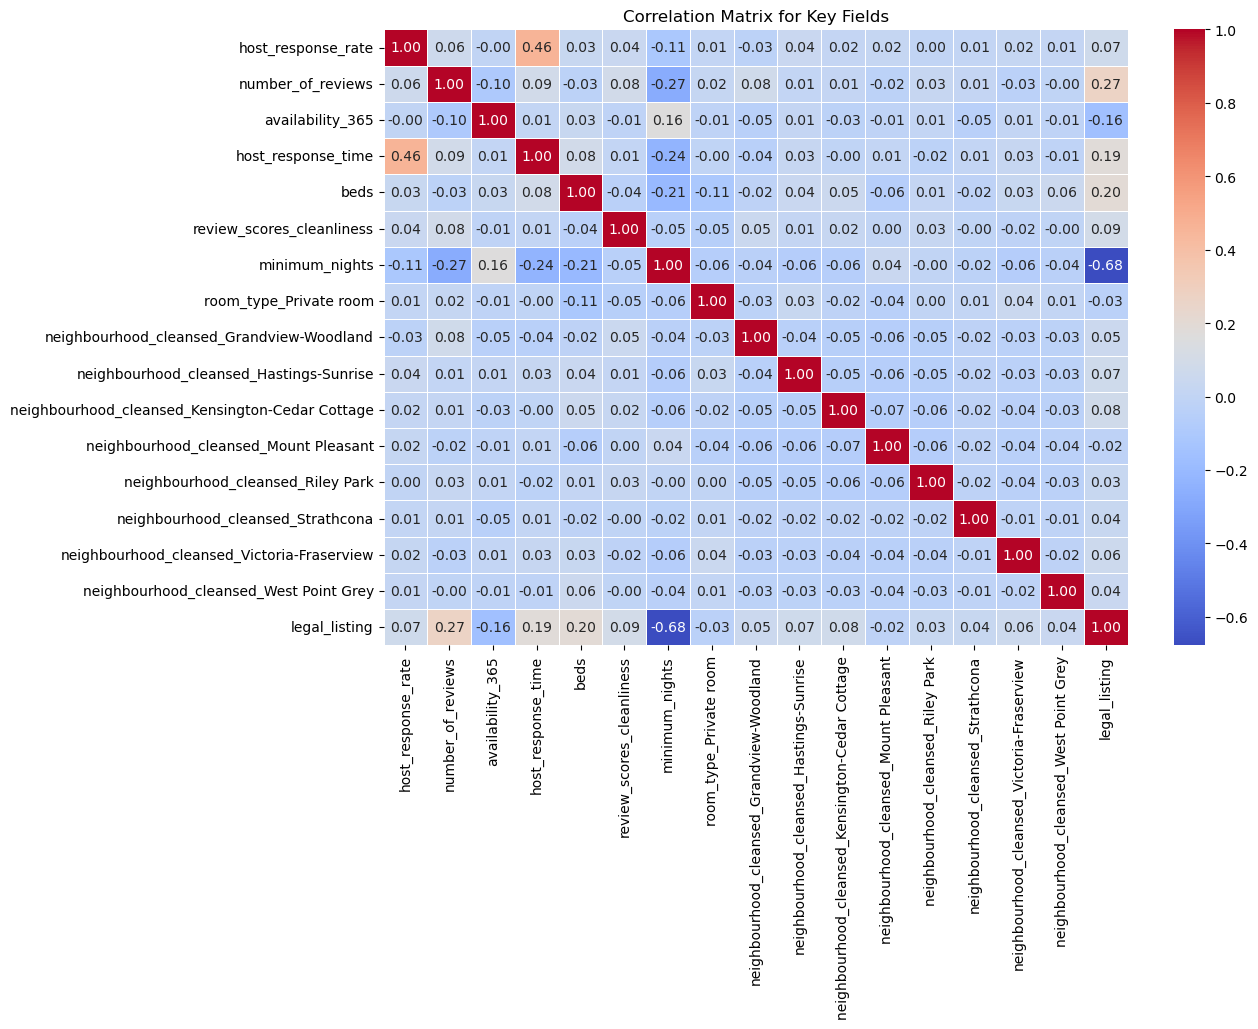

In [154]:
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix for Key Fields')
plt.show()

In [27]:

# Get the columns that start with "neighbourhood_cleansed"
neighbourhood_columns = [col for col in key_fields.columns if col.startswith('neighbourhood_cleansed')]

# Create a new dataframe to store the neighbourhood information
neighbourhood_df = pd.DataFrame()

# Iterate over each neighbourhood column
for col in neighbourhood_columns:
    # Get the neighbourhood name
    neighbourhood = col.split('_')[2]
    
    # Calculate the total number of listings in the neighbourhood
    total_listings = key_fields[key_fields[col] == 1].shape[0]
    
    # Calculate the total number of legal listings in the neighbourhood
    total_legal_listings = key_fields[(key_fields[col] == 1) & (key_fields['legal_listing'] == 1)].shape[0]
    
    # Calculate the total number of illegal listings in the neighbourhood
    total_illegal_listings = key_fields[(key_fields[col] == 1) & (key_fields['legal_listing'] == 0)].shape[0]
    
    # Create a new dataframe with the neighbourhood information
    neighbourhood_info = pd.DataFrame({'Neighbourhood': [neighbourhood],
                                       'Total Listings': [total_listings],
                                       'Total Legal Listings': [total_legal_listings],
                                       'Total Illegal Listings': [total_illegal_listings]})
    
    # Concatenate the new dataframe with the neighbourhood_df dataframe
    neighbourhood_df = pd.concat([neighbourhood_df, neighbourhood_info], ignore_index=True)
    
# Display the new dataframe
neighbourhood_df



,Neighbourhood,Total Listings,Total Legal Listings,Total Illegal Listings
0,Grandview-Woodland,150,132,18
1,Hastings-Sunrise,157,144,13
2,Kensington-Cedar Cottage,207,189,18
3,Mount Pleasant,241,181,60
4,Riley Park,192,161,31
5,Strathcona,24,23,1
6,Victoria-Fraserview,86,80,6
7,West Point Grey,60,55,5


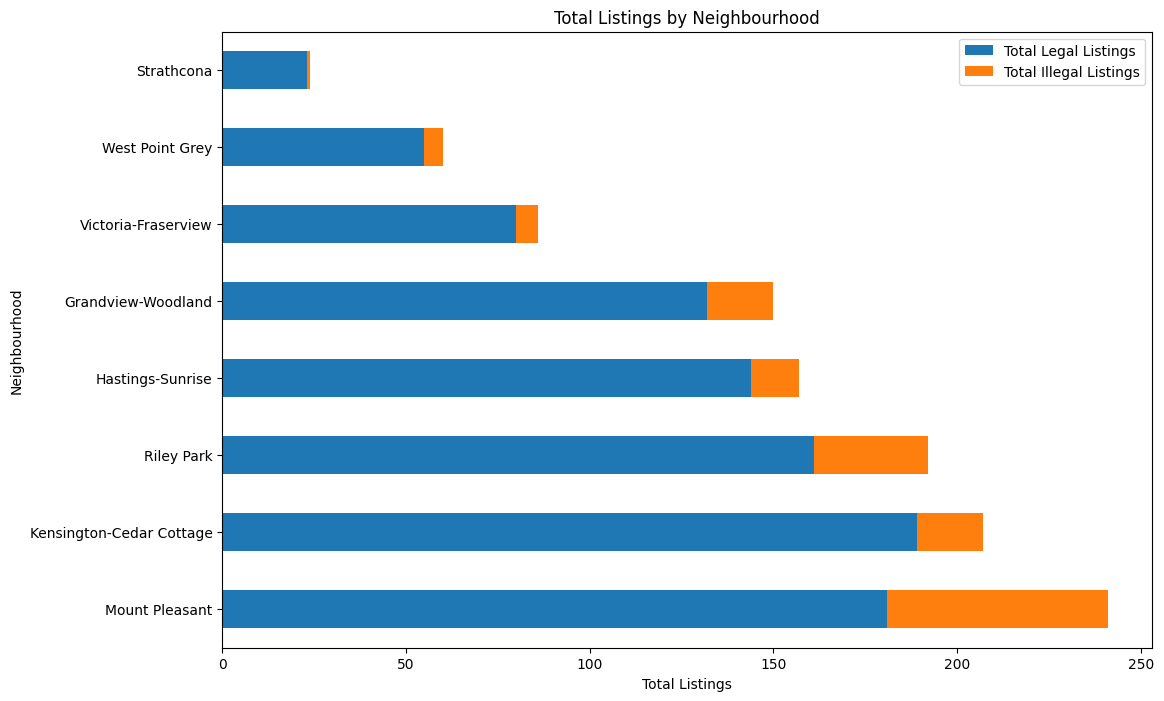

In [36]:
# Sort the dataframe by the desired column
neighbourhood_df_sorted = neighbourhood_df.sort_values(by='Total Listings', ascending=False)

# Create a stacked bar chart of neighbourhood_df
neighbourhood_df_sorted.drop('Total Listings', axis=1).plot.barh(x='Neighbourhood', stacked=True, figsize=(12, 8))
plt.title('Total Listings by Neighbourhood')
plt.xlabel('Total Listings')
plt.ylabel('Neighbourhood')

# save figure with transparent background
plt.savefig('total_listings_by_neighbourhood.png', transparent=True)

plt.show()


C:\Users\juane\AppData\Local\Temp\ipykernel_6516\4007536024.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.text(i, count/2, f"{percentages[i]:.2f}%", ha='center', va='center')


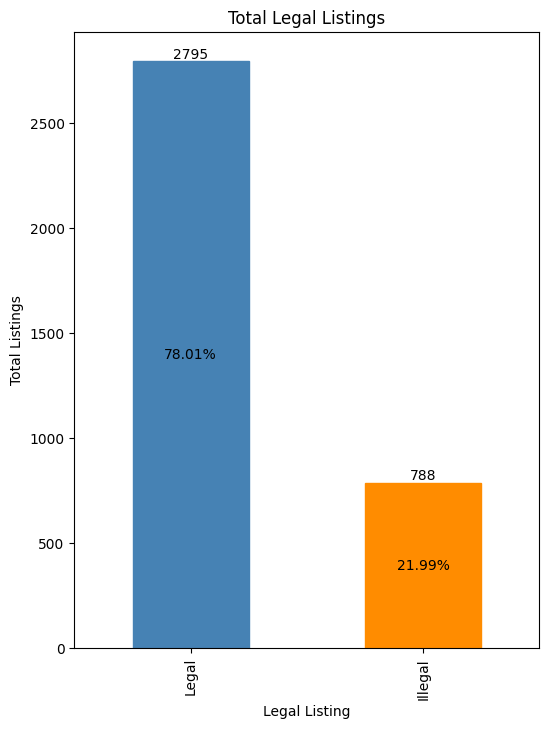

In [60]:
legal_listings_counts = key_fields['legal_listing'].value_counts()

# CHange the value index to "Legal" and "Illegal"
legal_listings_counts.index = ['Legal', 'Illegal']


# Calculate the total number of listings
total_listings = legal_listings_counts.sum()

# Calculate the percentages
percentages = legal_listings_counts / total_listings * 100

# Create the stacked bar chart
legal_listings_counts.plot.bar(figsize=(6, 8), stacked=True)

# Change colors
plt.gca().patches[0].set_color('steelblue')
plt.gca().patches[1].set_color('darkorange')

# Add the counts and percentages to each bar
for i, count in enumerate(legal_listings_counts):
    plt.text(i, count, str(count), ha='center', va='bottom')
    plt.text(i, count/2, f"{percentages[i]:.2f}%", ha='center', va='center')

plt.title('Total Legal Listings')
plt.xlabel('Legal Listing')
plt.ylabel('Total Listings')


# save figure with transparent background
plt.savefig('total_legal_listings.png', transparent=True)

plt.show()

### 3. Appropriate Plots for Communicating Key Field Distributions:

Print boxplot and histogram to identify outliers, mean and spread

#### 3.1 Boxplot for key fields

/opt/conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dty

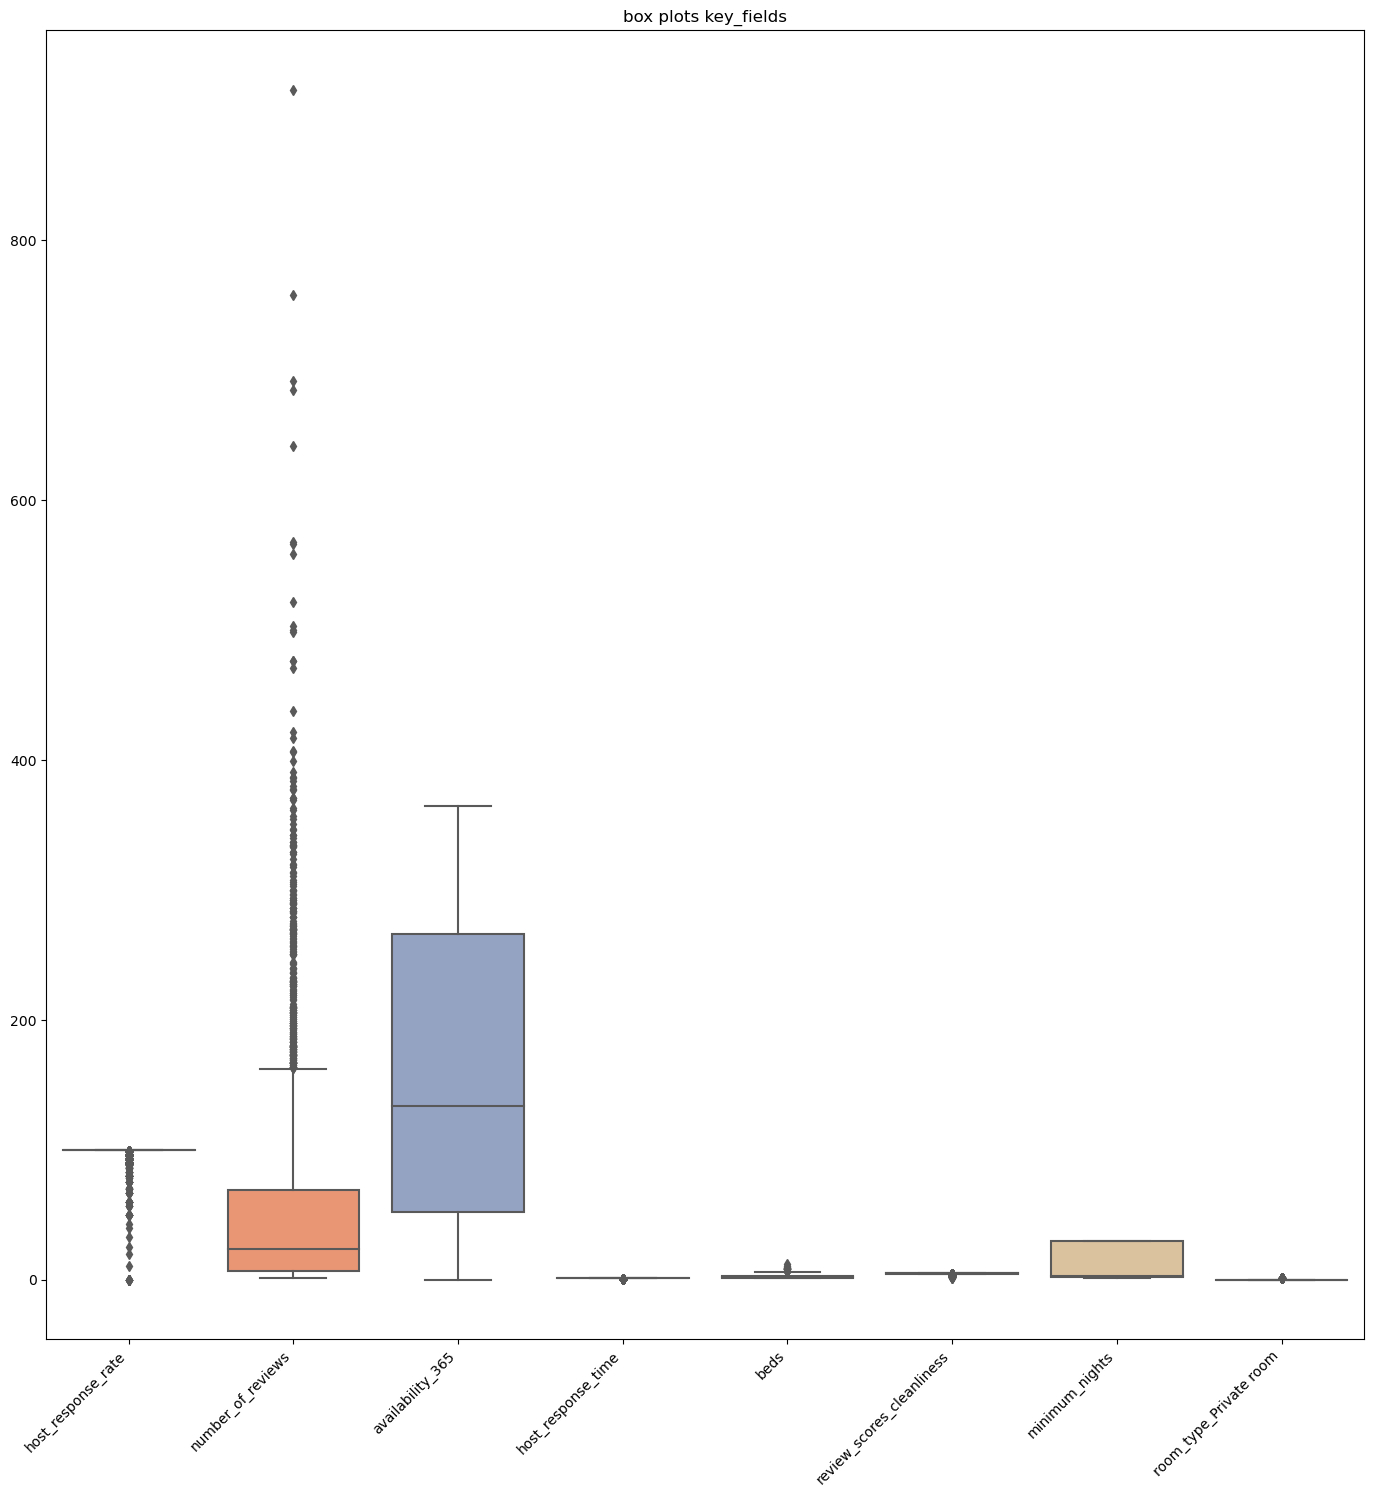

In [122]:
# boxplots for key fields
plt.figure(figsize=(17, 17))
sns.boxplot(data=yvr_key_fields_no_neighbourhoods_df, palette='Set2')
plt.title('box plots key_fields')
plt.xticks(rotation=45, ha='right')
plt.show()

#### 3.2 Histograms for key fields

<Figure size 1600x1000 with 0 Axes>

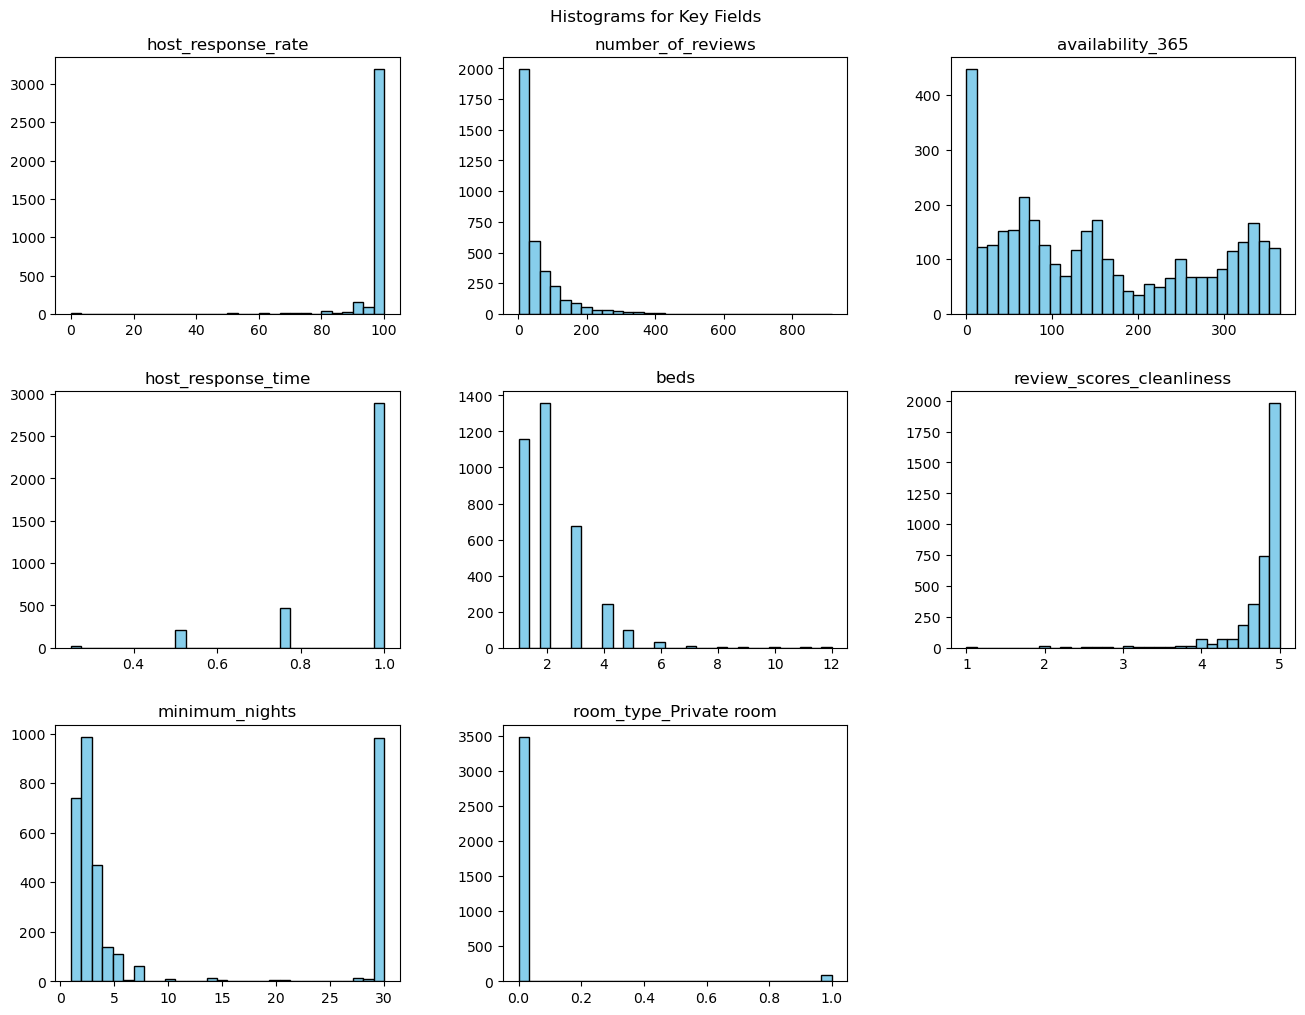

In [120]:
plt.figure(figsize=(16, 10))
yvr_key_fields_no_neighbourhoods_df.hist(bins=30, figsize=(16, 12), color='skyblue', edgecolor='black', grid=False)
plt.suptitle('Histograms for Key Fields', x=0.5, y=0.92, ha='center', fontsize='large')
plt.show()

#### 3.3 Regression Model for each field ~ 'legal_listing'


Regression Results for host_response_rate:
                            OLS Regression Results                            
Dep. Variable:          legal_listing   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     19.94
Date:                Sat, 02 Dec 2023   Prob (F-statistic):           8.25e-06
Time:                        15:23:44   Log-Likelihood:                -1916.0
No. Observations:                3583   AIC:                             3836.
Df Residuals:                    3581   BIC:                             3848.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------

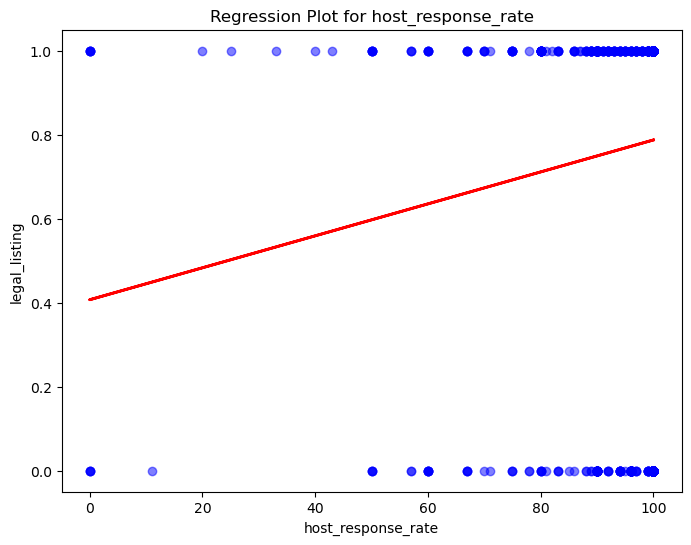


Regression Results for number_of_reviews:
                            OLS Regression Results                            
Dep. Variable:          legal_listing   R-squared:                       0.072
Model:                            OLS   Adj. R-squared:                  0.072
Method:                 Least Squares   F-statistic:                     279.6
Date:                Sat, 02 Dec 2023   Prob (F-statistic):           1.68e-60
Time:                        15:23:47   Log-Likelihood:                -1791.3
No. Observations:                3583   AIC:                             3587.
Df Residuals:                    3581   BIC:                             3599.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------

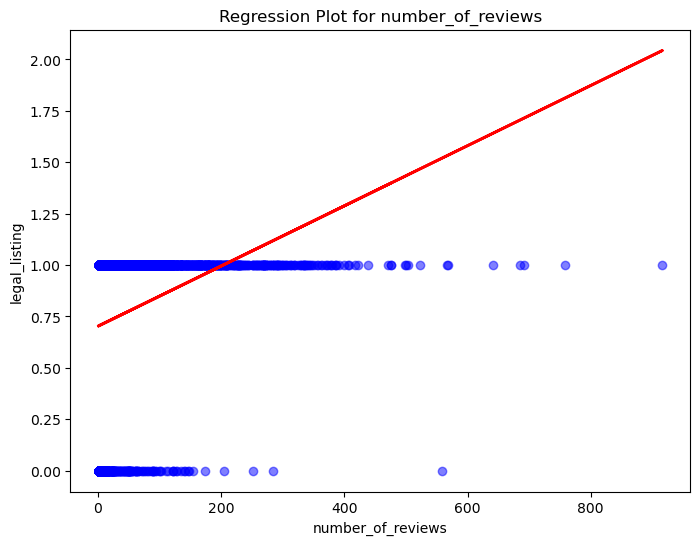


Regression Results for availability_365:
                            OLS Regression Results                            
Dep. Variable:          legal_listing   R-squared:                       0.027
Model:                            OLS   Adj. R-squared:                  0.027
Method:                 Least Squares   F-statistic:                     99.57
Date:                Sat, 02 Dec 2023   Prob (F-statistic):           3.78e-23
Time:                        15:23:50   Log-Likelihood:                -1876.8
No. Observations:                3583   AIC:                             3758.
Df Residuals:                    3581   BIC:                             3770.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------

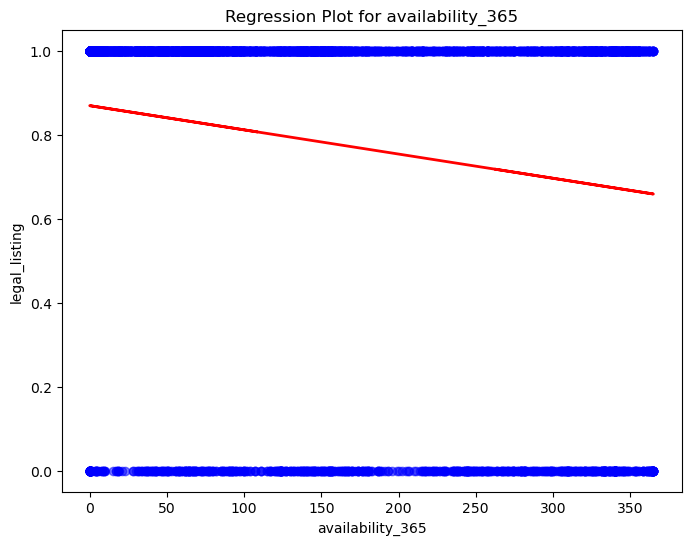


Regression Results for host_response_time:
                            OLS Regression Results                            
Dep. Variable:          legal_listing   R-squared:                       0.034
Model:                            OLS   Adj. R-squared:                  0.034
Method:                 Least Squares   F-statistic:                     127.9
Date:                Sat, 02 Dec 2023   Prob (F-statistic):           3.58e-29
Time:                        15:23:52   Log-Likelihood:                -1863.1
No. Observations:                3583   AIC:                             3730.
Df Residuals:                    3581   BIC:                             3742.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------

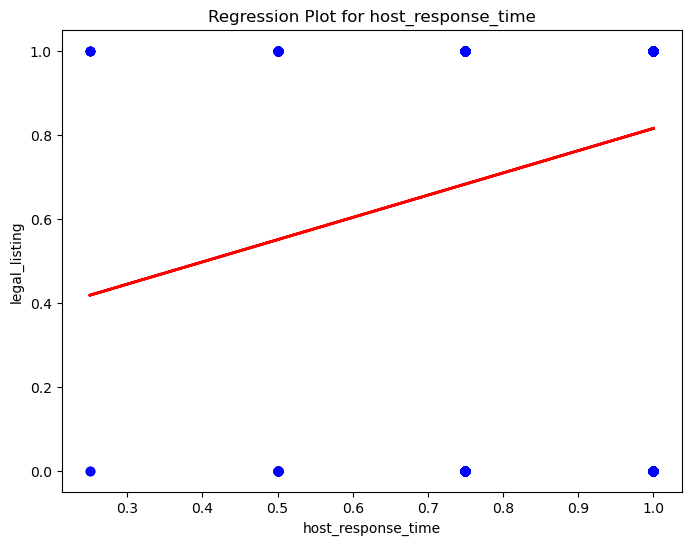


Regression Results for beds:
                            OLS Regression Results                            
Dep. Variable:          legal_listing   R-squared:                       0.039
Model:                            OLS   Adj. R-squared:                  0.039
Method:                 Least Squares   F-statistic:                     146.8
Date:                Sat, 02 Dec 2023   Prob (F-statistic):           3.91e-33
Time:                        15:23:55   Log-Likelihood:                -1854.0
No. Observations:                3583   AIC:                             3712.
Df Residuals:                    3581   BIC:                             3724.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6296 

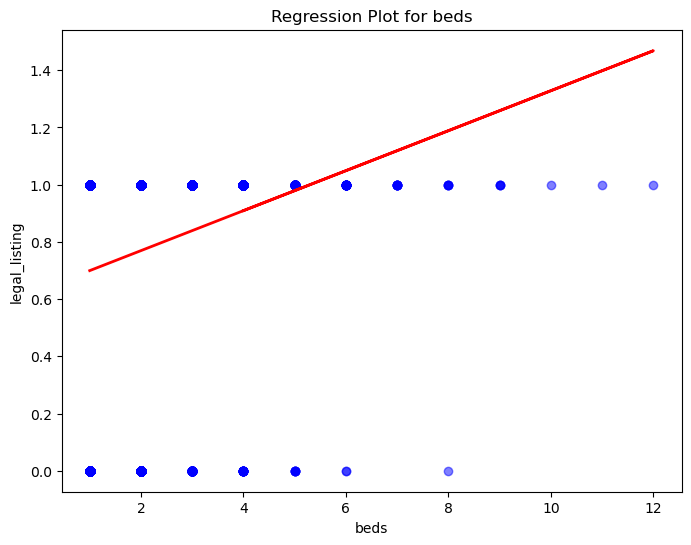


Regression Results for review_scores_cleanliness:
                            OLS Regression Results                            
Dep. Variable:          legal_listing   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     30.61
Date:                Sat, 02 Dec 2023   Prob (F-statistic):           3.38e-08
Time:                        15:23:58   Log-Likelihood:                -1910.7
No. Observations:                3583   AIC:                             3825.
Df Residuals:                    3581   BIC:                             3838.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------

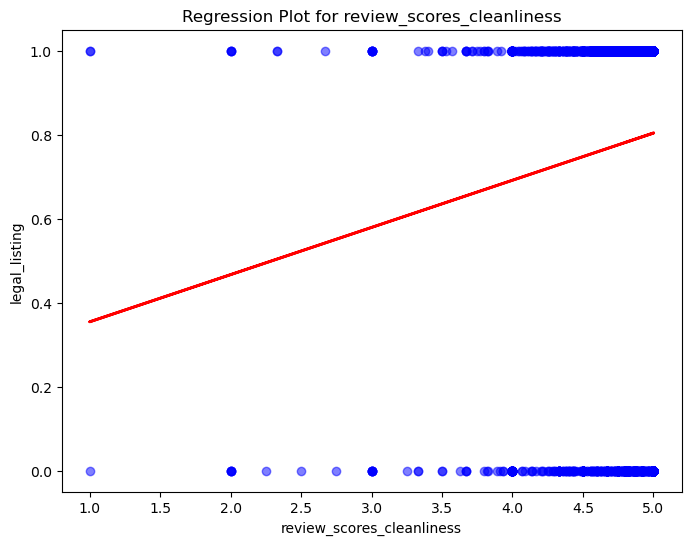


Regression Results for minimum_nights:
                            OLS Regression Results                            
Dep. Variable:          legal_listing   R-squared:                       0.459
Model:                            OLS   Adj. R-squared:                  0.459
Method:                 Least Squares   F-statistic:                     3042.
Date:                Sat, 02 Dec 2023   Prob (F-statistic):               0.00
Time:                        15:24:01   Log-Likelihood:                -824.46
No. Observations:                3583   AIC:                             1653.
Df Residuals:                    3581   BIC:                             1665.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
cons

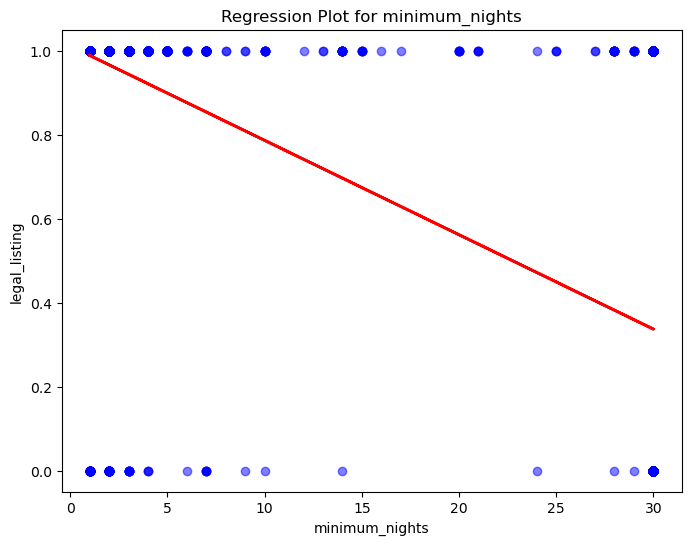


Regression Results for room_type_Private room:
                            OLS Regression Results                            
Dep. Variable:          legal_listing   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     3.925
Date:                Sat, 02 Dec 2023   Prob (F-statistic):             0.0477
Time:                        15:24:04   Log-Likelihood:                -1924.0
No. Observations:                3583   AIC:                             3852.
Df Residuals:                    3581   BIC:                             3864.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------

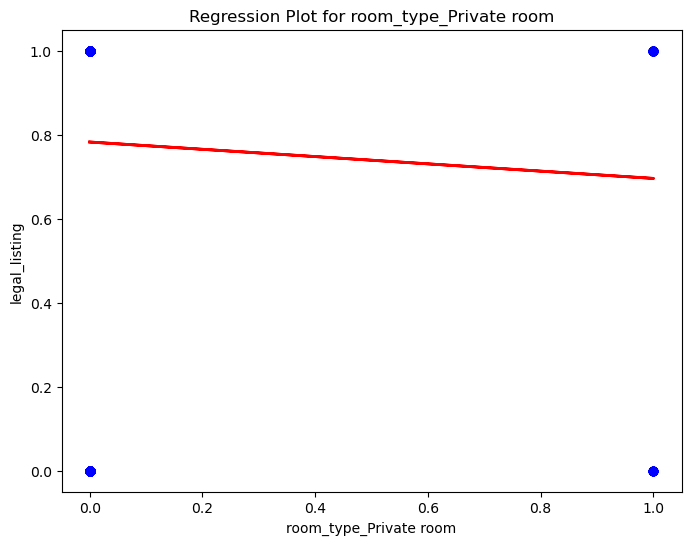

In [132]:
import statsmodels.api as sm

for column in yvr_key_fields_no_neighbourhoods_df.columns:
    if column != 'legal_listing':
        X = yvr_key_fields_no_neighbourhoods_df[column]
        y = yvr_key_fields_no_neighbourhoods_df['legal_listing']

        # add intercept
        X = sm.add_constant(X)

        # regression model
        model = sm.OLS(y, X).fit()

        # print regression results
        print(f"\nRegression Results for {column}:")
        print(model.summary())

        # plot
        plt.figure(figsize=(8, 6))
        plt.scatter(X.iloc[:, 1], y, color='blue', alpha=0.5)
        plt.plot(X.iloc[:, 1], model.predict(X), color='red', linewidth=2)
        plt.title(f'Regression Plot for {column}')
        plt.xlabel(column)
        plt.ylabel('legal_listing')
        plt.show()

#### 3.4 Multiple logistic regression for key fields ~ 'legal_listings'

In [139]:
#define x and y
y = yvr_key_fields_no_neighbourhoods_df['legal_listing']
X = yvr_key_fields_no_neighbourhoods_df.drop(columns=['legal_listing'])

# add intercept
X = sm.add_constant(X)

# fit model
model = sm.Logit(y, X).fit()

# logistic regression results
print("\nLogistic Regression Results:")
print(model.summary())

Optimization terminated successfully.
         Current function value: 0.271203
         Iterations 8

Logistic Regression Results:
                           Logit Regression Results                           
Dep. Variable:          legal_listing   No. Observations:                 3583
Model:                          Logit   Df Residuals:                     3574
Method:                           MLE   Df Model:                            8
Date:                Sat, 02 Dec 2023   Pseudo R-squ.:                  0.4852
Time:                        15:51:29   Log-Likelihood:                -971.72
converged:                       True   LL-Null:                       -1887.6
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                         0.3286      0.868 